In [35]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
import interpolation
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_tree

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [76]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

In [52]:
census_1850_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514718 entries, 0 to 514717
Data columns (total 36 columns):
block_num                  261427 non-null float64
CD_ADDRESS                 261427 non-null object
CD_X                       261427 non-null float64
CD_Y                       261427 non-null float64
CENSUS_AGE                 514718 non-null int64
CENSUS_CITY                514718 non-null int64
CENSUS_DWELLING_NUM        514718 non-null float64
CENSUS_DWELLING_SEQ        513135 non-null float64
CENSUS_DWELLING_SIZE       514718 non-null int64
CENSUS_GEOG                514006 non-null object
CENSUS_HH_NUM              514718 non-null int64
CENSUS_ID                  12315 non-null object
CENSUS_IMPREL              514718 non-null int64
CENSUS_INDEX               514718 non-null int64
CENSUS_IPUMS_UID           514718 non-null object
CENSUS_LABFORCE            514718 non-null int64
CENSUS_LINE                514718 non-null int64
CENSUS_MARST               514718 non-null 

In [21]:
cols = ["street_name", "sequence_id", "WARD_NUM", "CENSUS_SERIALB", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [22]:
model_gboost = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                         ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, colsample_bytree = 0.5, alpha = 1))])

In [24]:
model_gboost.fit(train_X, train_y)
print("Training Score:", model_gboost.score(train_X, train_y))
print("1880 Test Score:", model_gboost.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost.score(test_1850_X, test_1850_y))

Training Score: 0.9908513263003917
1880 Test Score: 0.9700777158301085
1850 Test Score: 0.9576060742752103


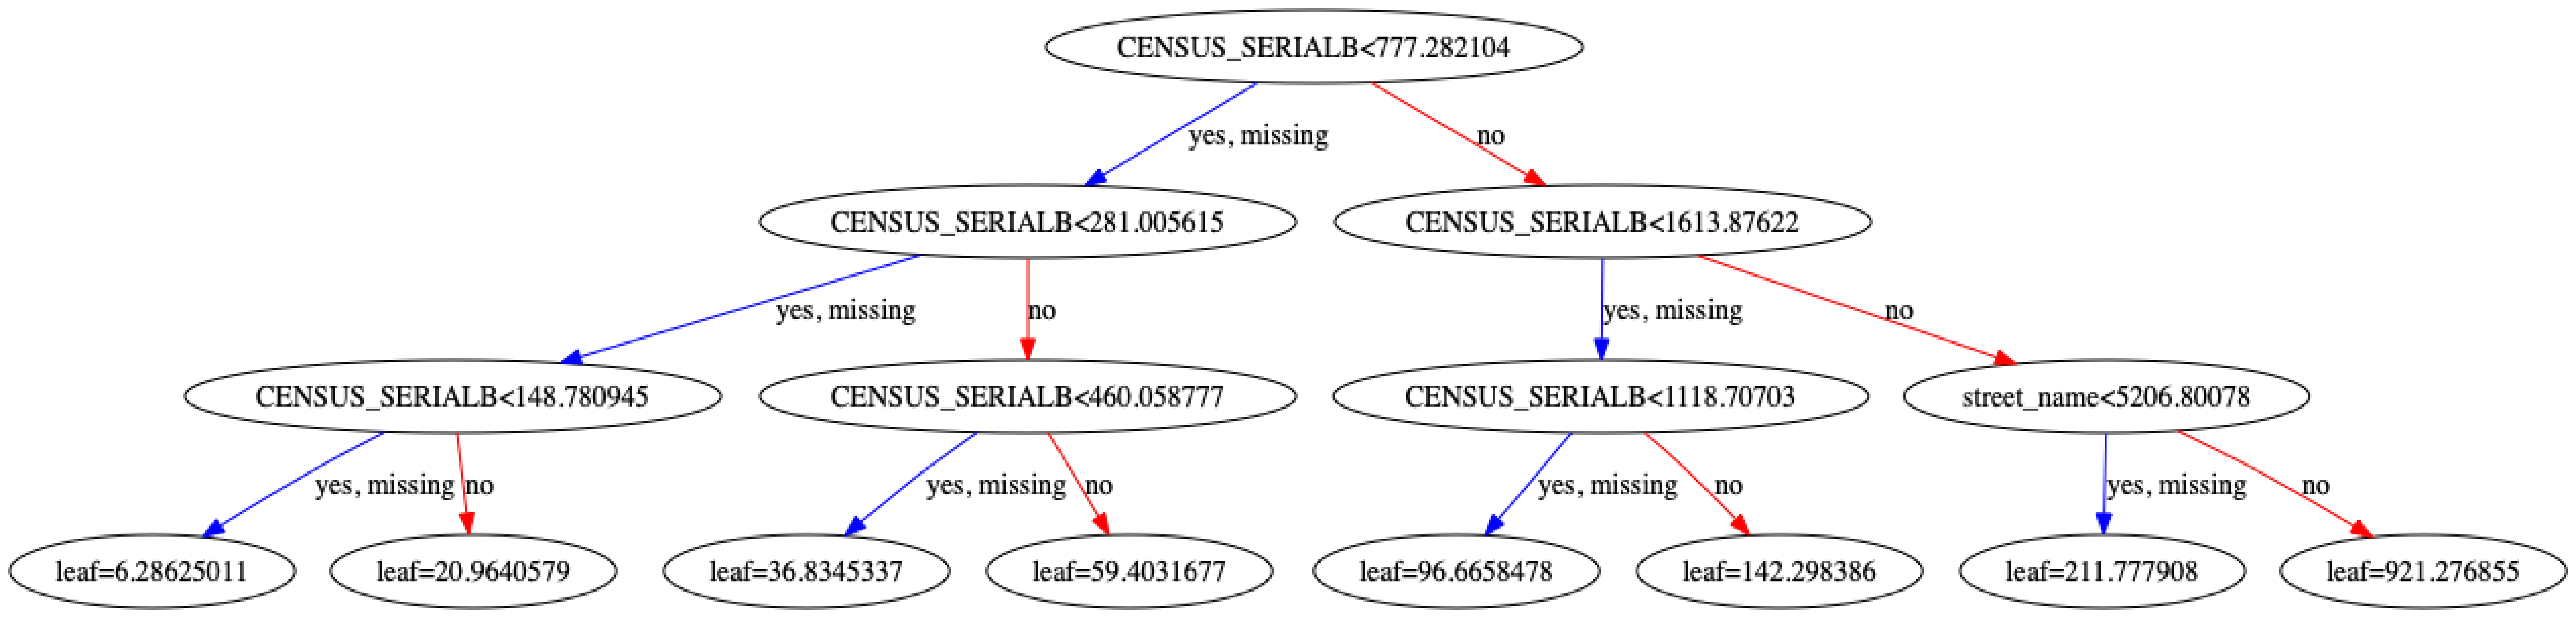

In [40]:
plot_tree(model_gboost.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [26]:
# Let's try with just training with just 1850 data
train_X_1850, test_X_1850, train_y_1850, test_y_1850 = train_test_split(census_1850_model.dropna(subset = ["house_number"]).loc[:,cols], census_1850_model.dropna(subset = ["house_number"]).loc[:,"house_number"])
model_gboost_1850 = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [28]:
model_gboost_1850.fit(train_X_1850, train_y_1850)
print("Training Score:", model_gboost_1850.score(train_X_1850, train_y_1850))
print("1880 Test Score:", model_gboost_1850.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_1850.score(test_X_1850, test_y_1850))

Training Score: 0.9936607453643951
1880 Test Score: -0.15040280987450227
1850 Test Score: 0.9799798631244744


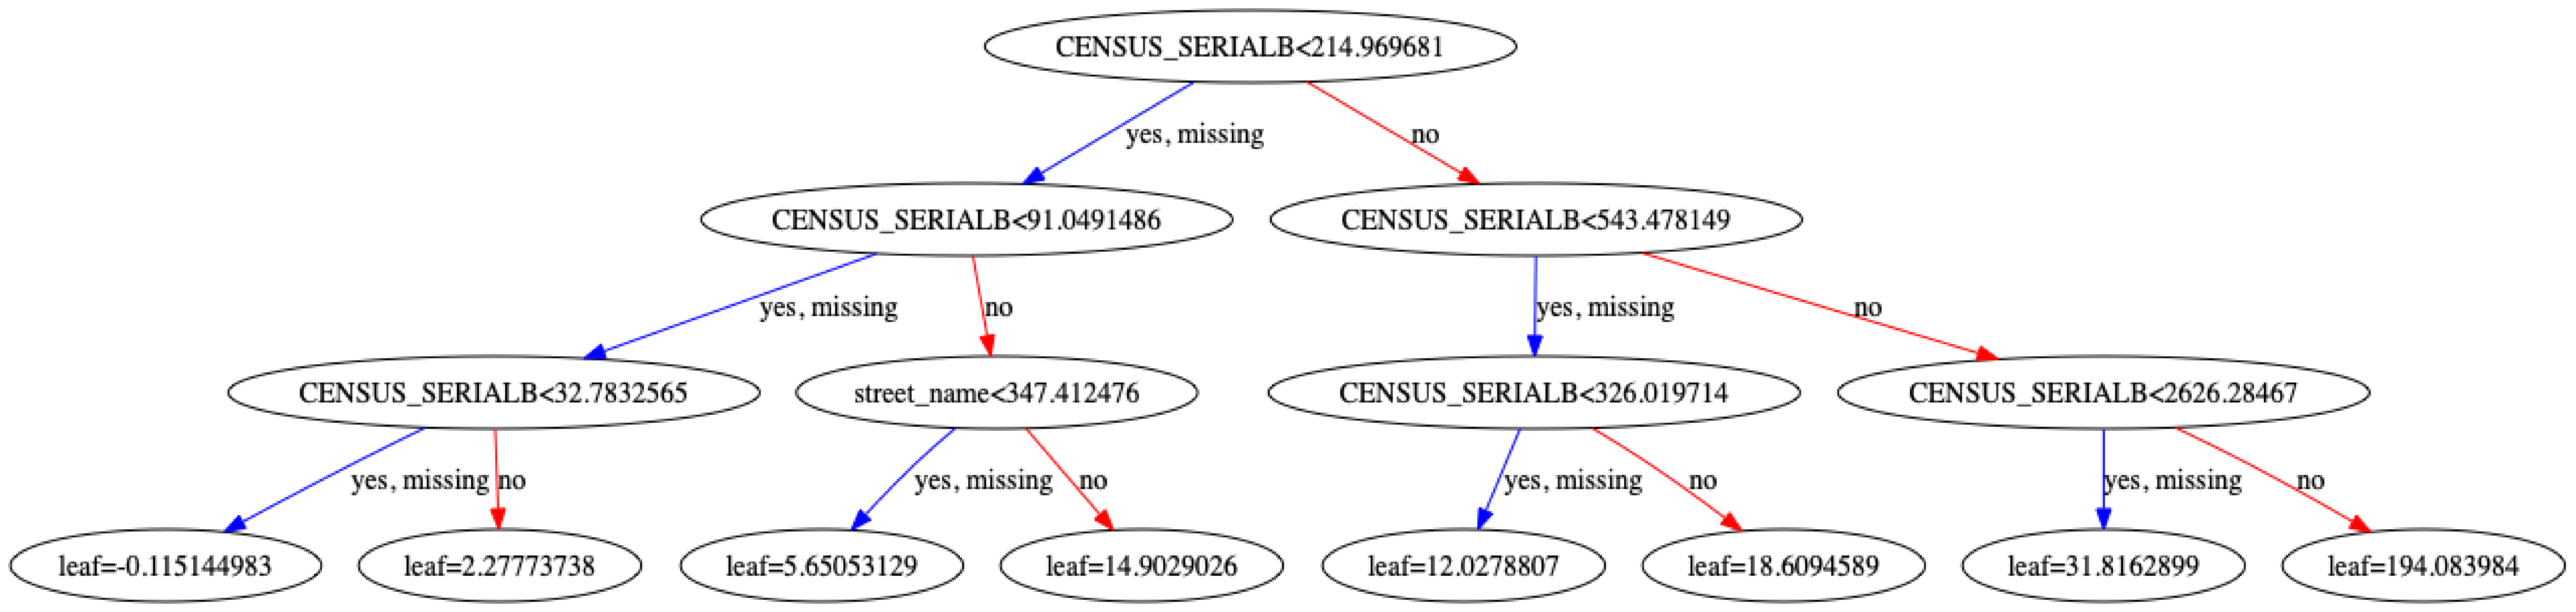

In [69]:
plot_tree(model_gboost_1850.named_steps["regressor"], num_trees = 8)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [32]:
#Let's try training the linear model with just the 1850 data
lin_mod = Pipeline([('preprocess', TargetEncoder(cols = ["CENSUS_SERIALB","WARD_NUM","street_name", "sequence_id", "block_num"])),
                    ('regressor', LinearRegression())])
lin_mod.fit(train_X_1850.fillna("None"), train_y_1850)
print("Training Score:", lin_mod.score(train_X_1850.fillna("None"), train_y_1850))
print("1880 Test Score:", lin_mod.score(test_1880_X.fillna("None"), test_1880_y))
print("1850 Test Score:", lin_mod.score(test_X_1850.fillna("None"), test_y_1850))

Training Score: 0.9585897967818585
1880 Test Score: -0.18344274899245017
1850 Test Score: 0.8958136884943351


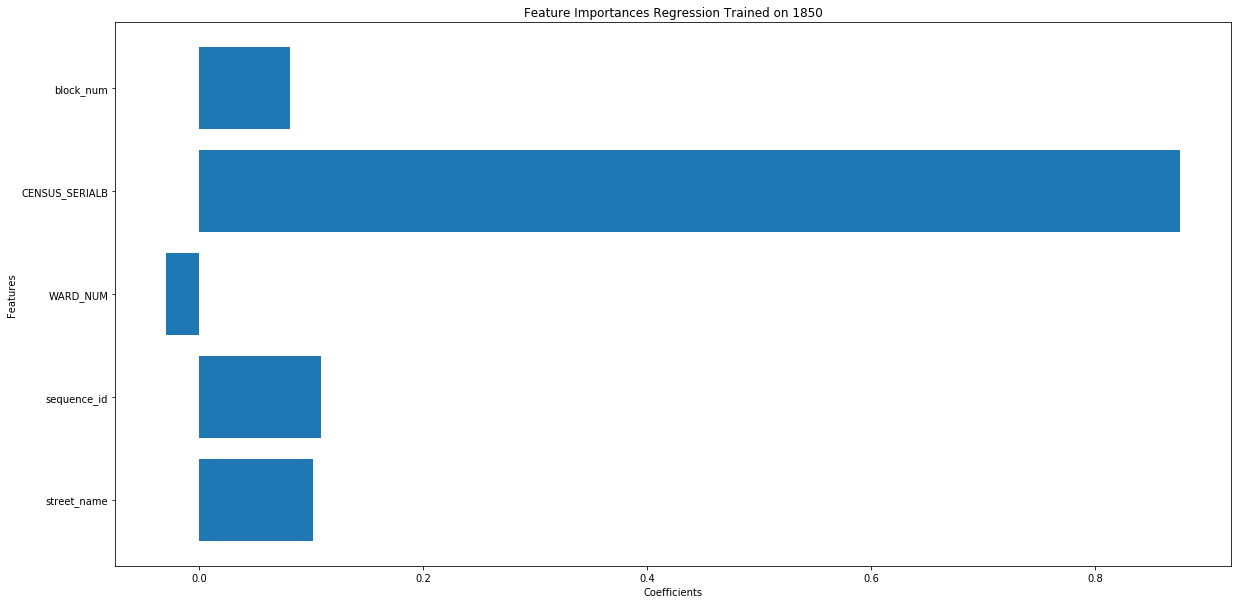

In [34]:
interpolation.graph_coefs(lin_mod.named_steps['preprocess'].get_feature_names(), lin_mod.named_steps['regressor'].coef_, "Feature Importances Regression Trained on 1850")

### Investigate SerialB Importance

In [53]:
cols = ["street_name", "sequence_id", "WARD_NUM", "block_num", "sequence_order"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [55]:
model_gboost_noB = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [56]:
model_gboost_noB.fit(train_X, train_y)
print("Training Score:", model_gboost_noB.score(train_X, train_y))
print("1880 Test Score:", model_gboost_noB.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_noB.score(test_1850_X, test_1850_y))

Training Score: 0.9635943576566758
1880 Test Score: 0.9675414282537227
1850 Test Score: 0.8520772211107956


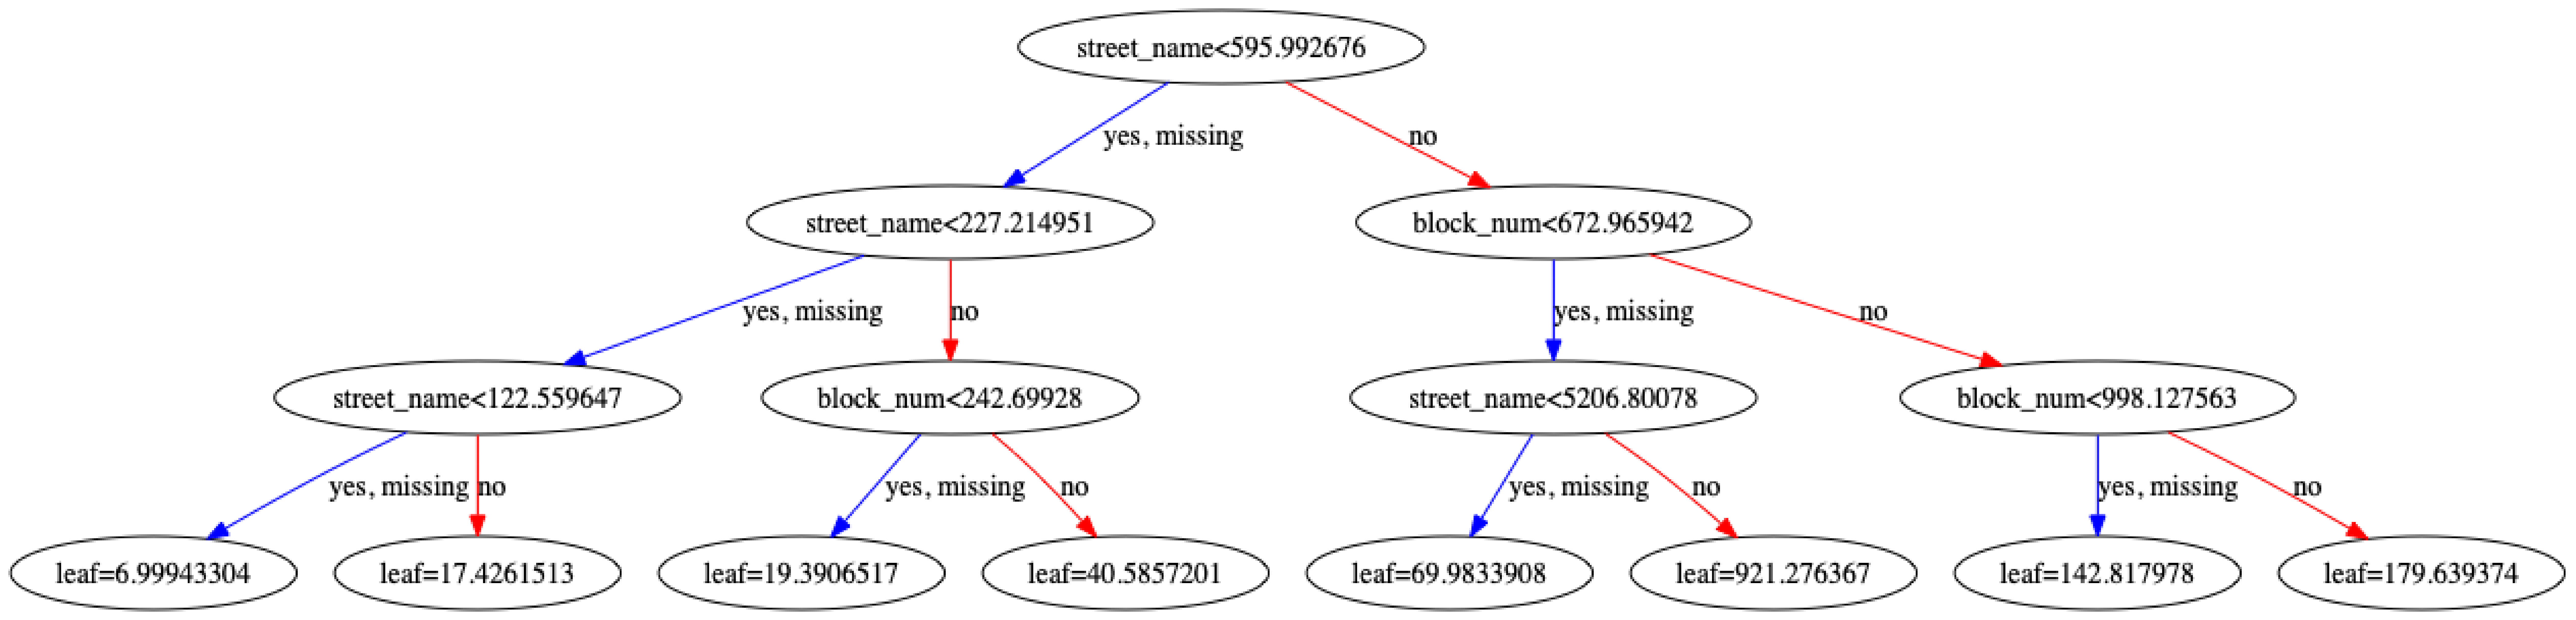

In [57]:
plot_tree(model_gboost_noB.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [64]:
#let's do it at the dwelling level (ei: maybe serialB is helping with dealing with duplicates?)
cols = ["street_name", "sequence_id", "WARD_NUM", "block_num", "sequence_order"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(dwellings_1880, dwellings_1850, cols)

In [65]:
model_gboost_dwell = Pipeline([('preprocess', TargetEncoder(cols = cols)),
                            ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5))])

In [66]:
model_gboost_dwell.fit(train_X, train_y)
print("Training Score:", model_gboost_dwell.score(train_X, train_y))
print("1880 Test Score:", model_gboost_dwell.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_gboost_dwell.score(test_1850_X, test_1850_y))

Training Score: 0.9650635033319362
1880 Test Score: 0.9623443931250656
1850 Test Score: 0.5003441226876302


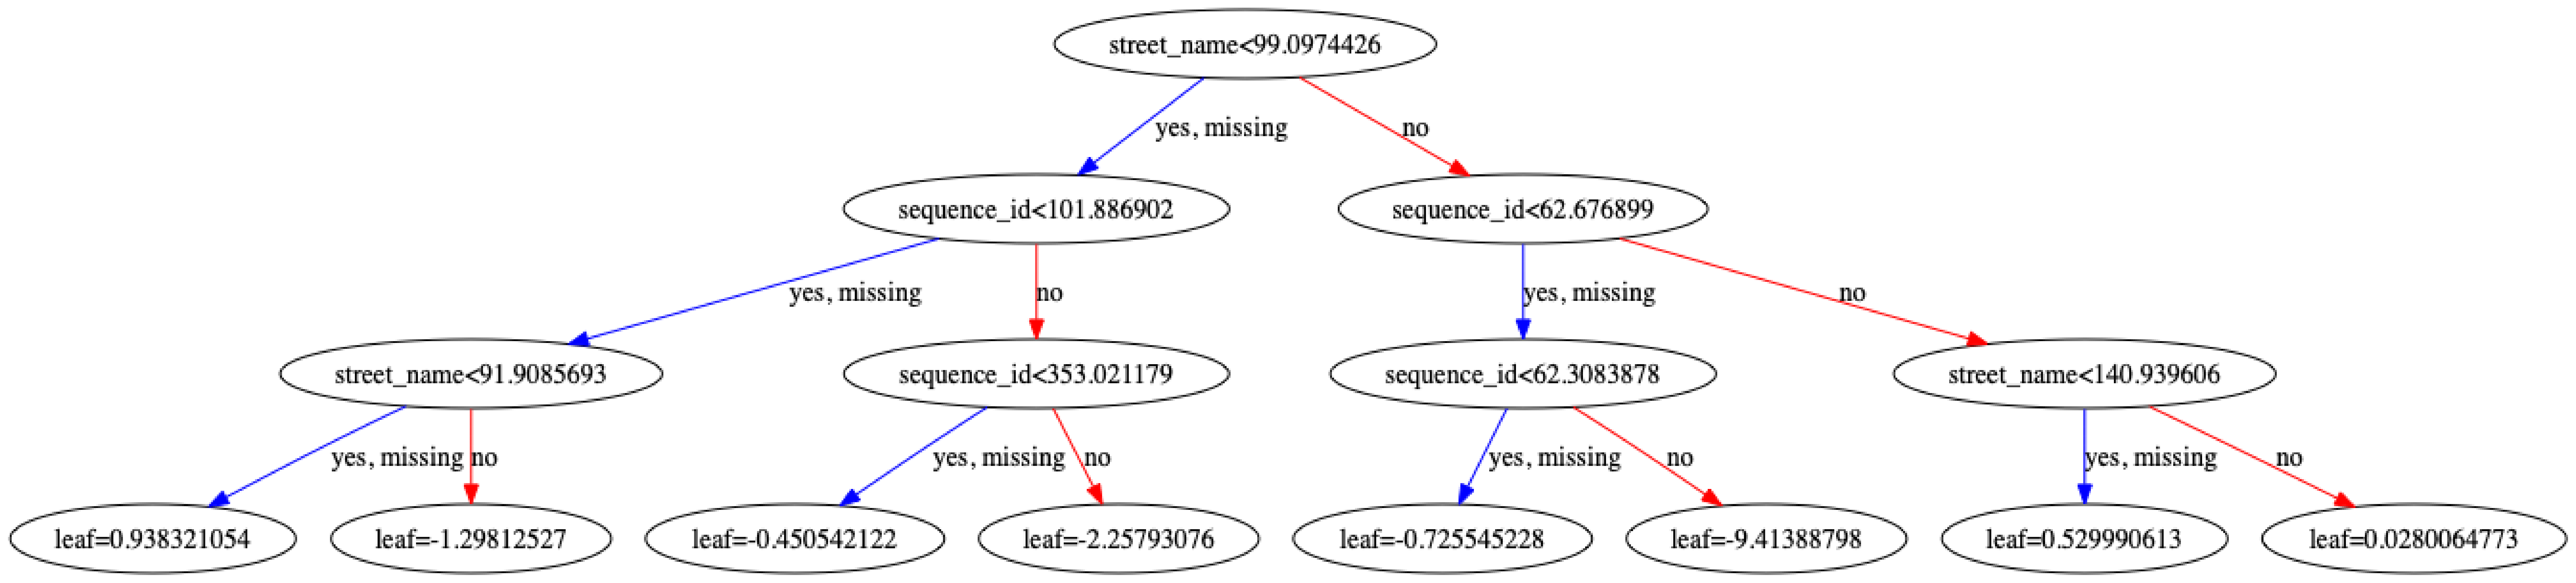

In [72]:
plot_tree(model_gboost_dwell.named_steps["regressor"], num_trees = 500)
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

### Let's Try to Get a Sense of How This Works On Our Use Case

#### First we need to create a dataset where we are reasonably sure of what the street names are

In [75]:
census_1850_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 514718 entries, 0 to 514717
Data columns (total 36 columns):
block_num                  261427 non-null float64
CD_ADDRESS                 261427 non-null object
CD_X                       261427 non-null float64
CD_Y                       261427 non-null float64
CENSUS_AGE                 514718 non-null int64
CENSUS_CITY                514718 non-null int64
CENSUS_DWELLING_NUM        514718 non-null float64
CENSUS_DWELLING_SEQ        513135 non-null float64
CENSUS_DWELLING_SIZE       514718 non-null int64
CENSUS_GEOG                514006 non-null object
CENSUS_HH_NUM              514718 non-null int64
CENSUS_ID                  12315 non-null object
CENSUS_IMPREL              514718 non-null int64
CENSUS_INDEX               514718 non-null int64
CENSUS_IPUMS_UID           514718 non-null object
CENSUS_LABFORCE            514718 non-null int64
CENSUS_LINE                514718 non-null int64
CENSUS_MARST               514718 non-null 

In [93]:
dwellings_1850["street_name_next"] = dwellings_1850["street_name"].shift(-1)
dwellings_1850_predict = dwellings_1850[dwellings_1850["street_name_next"] == dwellings_1850["street_name"]]

In [94]:
print("Range of dwellings between records with known consecutive streets:", min(dwellings_1850_predict.num_between), "-", max(dwellings_1850_predict.num_between))

Range of dwellings between records with known consecutive streets: 1.0 - 19.0


In [82]:
dwellings_1850.head(10)

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_x,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,street_name_next
0,1.0,1.0,3794.0,37 South,-74.008250,40.703128,49.0,4610.0,1.0,84.0,...,-74.007679,40.707284,0.088400,3.0,5.0,6.0,3.0,37.0,South,Liberty
1,1.0,4.0,713.0,76 Liberty,-74.007679,40.707284,23.0,4610.0,4.0,1.0,...,-74.009067,40.707572,0.096077,2.0,5.0,6.0,5.0,76.0,Liberty,Cedar
2,1.0,6.0,709.0,46 Cedar,-74.009067,40.707572,25.0,4610.0,6.0,3.0,...,-74.011747,40.709673,0.189482,1.0,5.0,6.0,6.0,46.0,Cedar,Liberty |
3,1.0,7.0,682.0,102 Liberty |,-74.011747,40.709673,22.0,4610.0,7.0,1.0,...,-74.007680,40.705869,0.290189,2.0,6.0,2.0,2.0,102.0,Liberty |,Pearl
4,1.0,9.0,718.0,163 Pearl,-74.007680,40.705869,22.0,4610.0,9.0,1.0,...,-74.009386,40.707772,0.123281,12.0,21.0,19.0,12.0,163.0,Pearl,Cedar
5,1.0,21.0,709.0,58 Cedar,-74.009386,40.707772,26.0,4610.0,21.0,3.0,...,-74.008891,40.706125,0.046379,1.0,21.0,19.0,13.0,58.0,Cedar,Wall
6,1.0,22.0,718.0,54 Wall,-74.008891,40.706125,30.0,4610.0,22.0,1.0,...,-74.011213,40.709040,0.169758,6.0,21.0,19.0,19.0,54.0,Wall,Cedar
7,1.0,28.0,680.0,95 Cedar,-74.011213,40.709040,21.0,4610.0,28.0,3.0,...,-74.011293,40.709066,0.005536,1.0,28.0,2.0,1.0,95.0,Cedar,Cedar
8,1.0,29.0,680.0,97 Cedar,-74.011293,40.709066,32.0,4610.0,29.0,2.0,...,-74.008089,40.707039,0.224711,1.0,28.0,2.0,2.0,97.0,Cedar,Cedar
9,1.0,30.0,713.0,23 Cedar,-74.008089,40.707039,26.0,4610.0,30.0,4.0,...,-74.010228,40.706761,0.147859,9.0,38.0,11.0,9.0,23.0,Cedar,Wall


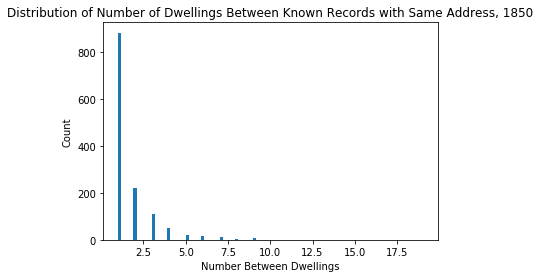

In [84]:
plt.hist(dwellings_1850_predict["num_between"], bins = "auto")
plt.title("Distribution of Number of Dwellings Between Known Records with Same Address, 1850")
plt.xlabel("Number Between Dwellings")
plt.ylabel("Count")
plt.show()

In [102]:
# Let's use 10 as a limit for what to fill in
dwellings_1850_predict_lim = dwellings_1850_predict[dwellings_1850_predict["num_between"] <= 5].copy()
total_to_fill = dwellings_1850_predict_lim[["num_between"]].sum()
print("Total dwellings we can fill in based on this:", total_to_fill - len(dwellings_1850_predict_lim))

Total dwellings we can fill in based on this: num_between    668.0
dtype: float64


In [103]:
print("This will increase the number of dwellings we know of by:", (total_to_fill - len(dwellings_1850_predict_lim))/filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"]).ngroups)

This will increase the number of dwellings we know of by: num_between    0.033695
dtype: float64


So this won't really improve the dwelling match rate that much (from 0.38 to 0.41) but hopefully it'll and provide validation that this approach is working. Then once we can work on street prediction, we can apply this process again to get good matches.

In [104]:
#So what I really want is the dataset of values in between
#Well, I guess we don't really need to drop these, we can just predict them too...
dwellings_1850_predict_lim.reset_index(drop = True).head()

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_x,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,street_name_next
0,1.0,28.0,680.0,95 Cedar,-74.011213,40.709040,21.0,4610.0,28.0,3.0,...,-74.011293,40.709066,0.005536,1.0,28.0,2.0,1.0,95.0,Cedar,Cedar
1,1.0,29.0,680.0,97 Cedar,-74.011293,40.709066,32.0,4610.0,29.0,2.0,...,-74.008089,40.707039,0.224711,1.0,28.0,2.0,2.0,97.0,Cedar,Cedar
2,1.0,51.0,716.0,35 Wall,-74.010104,40.706670,30.0,4610.0,51.0,1.0,...,-74.010958,40.707407,0.060636,1.0,52.0,3.0,1.0,35.0,Wall,Wall
3,1.0,54.0,715.0,38 Wall,-74.009943,40.706758,65.0,4610.0,65.0,5.0,...,-74.010365,40.706860,0.029176,1.0,56.0,5.0,1.0,38.0,Wall,Wall
4,1.0,79.0,3797.0,6 Stone,-74.012503,40.704005,35.0,4610.0,186.0,6.0,...,-74.012503,40.704005,0.000000,1.0,81.0,7.0,4.0,6.0,Stone,Stone


In [105]:
#Let's add an indicator column for known addresses 
dwellings_1850_predict_lim["Known"] = 1

In [106]:
prediction_data_1850 = interpolation.dwellings_to_all(filled_1850, dwellings_1850_predict_lim, ["WARD_NUM", "CENSUS_DWELLING_NUM","CD_X", "CD_Y", "sequence_order", "house_number", "street_name", "street_name_next", "Known"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
prediction_data_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515630 entries, 0 to 515629
Data columns (total 39 columns):
block_num                  261460 non-null float64
CD_ADDRESS                 261460 non-null object
CD_X_x                     261460 non-null float64
CD_Y_x                     261460 non-null float64
CENSUS_AGE                 515630 non-null int64
CENSUS_CITY                515630 non-null int64
CENSUS_DWELLING_NUM        514718 non-null float64
CENSUS_DWELLING_SEQ        514020 non-null float64
CENSUS_DWELLING_SIZE       515630 non-null int64
CENSUS_GEOG                514918 non-null object
CENSUS_HH_NUM              515630 non-null int64
CENSUS_ID                  12348 non-null object
CENSUS_IMPREL              515630 non-null int64
CENSUS_INDEX               515630 non-null int64
CENSUS_IPUMS_UID           515630 non-null object
CENSUS_LABFORCE            515630 non-null int64
CENSUS_LINE                515630 non-null int64
CENSUS_MARST               515630 non-null 

,block_num,CD_ADDRESS,CD_X_x,CD_Y_x,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_NUM,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,CENSUS_GEOG,...,selected,spatial_weight,spatial_weight_sum,CD_X_y,CD_Y_y,sequence_order,house_number,street_name,street_name_next,Known
0,3794.0,37 South,-74.00825,40.703128,49,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3794.0,37 South,-74.00825,40.703128,36,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3794.0,37 South,-74.00825,40.703128,12,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3794.0,37 South,-74.00825,40.703128,40,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3794.0,37 South,-74.00825,40.703128,28,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3794.0,37 South,-74.00825,40.703128,10,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3794.0,37 South,-74.00825,40.703128,34,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3794.0,37 South,-74.00825,40.703128,29,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3794.0,37 South,-74.00825,40.703128,6,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3794.0,37 South,-74.00825,40.703128,0,4610,1.0,1.0,84,NEW YORK WARD 1 EASTERN DIVISION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
